<a href="https://colab.research.google.com/github/rohanwagh01/036-MachineLearning/blob/main/hw05.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#MIT 6.036 Fall 2021: Homework 5#
# Features

This colab notebook provides code and a framework for problems 1-7 of [the homework](https://openlearninglibrary.mit.edu/courses/course-v1:MITx+6.036+1T2019/courseware/Week3/week3_homework/).  You can work out your solutions here, then submit your results back on the homework page when ready.

In [5]:
%%capture
!pip install pymatgen

In [6]:
!rm -rf code_and_data_for_hw05*
!rm -rf mnist
!wget --no-check-certificate --quiet https://go.odl.mit.edu/subject/6.036/_static/catsoop/homework/hw05/code_and_data_for_hw05.zip
!unzip code_and_data_for_hw05.zip
!mv code_and_data_for_hw05/* .
  
from code_for_hw5_part1 import *
import code_for_hw5_part2 as hw5
import numpy as np
import sklearn
import sklearn.linear_model
import sklearn.model_selection

import plotly 
import plotly.graph_objects as go
import matplotlib.pyplot as plt

import pymatgen
import pymatgen.util.plotting as pymatplt
import pymatgen.core.periodic_table as periodic_table

Archive:  code_and_data_for_hw05.zip
   creating: code_and_data_for_hw05/
   creating: code_and_data_for_hw05/mnist/
  inflating: code_and_data_for_hw05/mnist/mnist_train4.png  
  inflating: code_and_data_for_hw05/mnist/mnist_train5.png  
  inflating: code_and_data_for_hw05/mnist/mnist_train7.png  
  inflating: code_and_data_for_hw05/mnist/mnist_train6.png  
  inflating: code_and_data_for_hw05/mnist/mnist_train2.png  
  inflating: code_and_data_for_hw05/mnist/mnist_train3.png  
  inflating: code_and_data_for_hw05/mnist/mnist_train1.png  
  inflating: code_and_data_for_hw05/mnist/mnist_train0.png  
  inflating: code_and_data_for_hw05/mnist/mnist_train8.png  
  inflating: code_and_data_for_hw05/mnist/mnist_train9.png  
  inflating: code_and_data_for_hw05/hw5_part2_main.py  
  inflating: code_and_data_for_hw05/data_benzene.npy  
  inflating: code_and_data_for_hw05/code_for_hw5_part2.py  
  inflating: code_and_data_for_hw05/auto-mpg.tsv  
  inflating: code_and_data_for_hw05/data_no_benzene

# Feature Transformation

## <section>2D) Encoding Discrete Values</section>

It is common to encode sets of discrete values, for machine learning, not as a single multi-valued feature, but using a one hot encoding. So, if there are $k$ values in the discrete set, we would transform that single multi-valued feature into $k$ binary-valued features, in which feature $i$ has value $+1$ if the original feature value was $i$ and has value $0$ (or $-1$) otherwise.

Write a function `one_hot` that takes as input $x$, a single feature value (between $1$ and $k$), and $k$, the total possible number of values this feature can take on, and transform it to a numpy column vector of $k$ binary features using a one-hot encoding (remember vectors have zero-based indexing).

In [7]:
def one_hot(x, k):
    output = np.zeros((k,1))
    output[x-1][0] = 1
    return output

In [8]:
test_one_hot(one_hot)

Passed! 



## 3) Polynomial Features

One systematic way of generating non-linear transformations of your input features is to consider the polynomials of increasing order.  Given a feature vector $x = [x_1, x_2, ..., x_d]^T$, we can map it into a new feature vector that contains all the factors in a polynomial of order $d$. For example, for $x = [x_1, x_2]^T$ and order 2, we get $$\phi(x) = [1, x_1, x_2, x_1x_2, x_1^2, x_2^2]^T$$ and for order 3, we get $$\phi(x) = [1, x_1, x_2, x_1x_2, x_1^2, x_2^2, x_1^2x_2, x_1x_2^2, x_1^3, x_2^3]^T.$$  

In the code that has been loaded, we have defined `make_polynomial_feature_fun` that, given the order, returns a feature transformation function (analogous to $\phi$ in the description).  You should use it in doing this problem.

In [9]:
## For example, make_polynomial_feature_fun could be used as follows:
import numpy as np

# Data
data = np.zeros((5,1))

# Generate transformation of order 2
transformation = make_polynomial_feature_fun(2)

# Use transformation on data
print('Data shape after transformation: ', transformation(data).shape)
# print(transformation(data))

Data shape after transformation:  (21, 1)


Now, we will visualize the decision boundaries we get from optimizing the linear logistic regressor with gradient descent for different orders of polynomial parameters.

In [10]:
#### Functions for plotting evaluation of our classifier #####

def train_classifer_max_iter(data, labels, max_iter, alpha=1e-5):
  clf = sklearn.linear_model.SGDClassifier(loss='log', alpha=alpha, max_iter=max_iter)
  thetas = []
  for iter in range(max_iter):
    clf.partial_fit(data, labels, classes=[0, 1])
    thetas.append((clf.coef_, clf.intercept_))
  return thetas

def make_image_predictions(clf, transformation, image_size=100, min_v=0., max_v=2.5):
  xs = np.linspace(min_v, max_v, image_size)
  xv, yv = np.meshgrid(xs, xs)
  grid_data = np.stack([xv.reshape(-1), yv.reshape(-1)], axis=0)
  data = transformation(grid_data).T
  image_predictions = clf.predict(data)
  return image_predictions.reshape(image_size, image_size)

def plotly_points_and_images_with_slider(points, labels, images, zmin=-0.1, zmax=1.1, colorscale='greys', min_v=0., max_v=2.5):
  N, image_size, image_size = images.shape

  # Shift and scale points to match imshow axis
  shifted_and_scaled_points = (points - min_v) * image_size / np.abs(max_v - min_v)

  # Make Heatmaps and Scatters
  fig = go.Figure(data=[go.Heatmap(z=images[i], visible=False, zmin=zmin, zmax=zmax,
                                   colorscale=colorscale, showscale=False) for i in range(N)] +
      [go.Scatter(x=shifted_and_scaled_points[:, 0], 
                  y=shifted_and_scaled_points[:, 1], 
                  marker=dict(color=labels, size=20), mode='markers')])
  fig.data[0].visible = True
  h, w = images[0].shape
  fig.update_layout(yaxis_range=[-0.5, h-0.5])
  fig.update_layout(xaxis_range=[-0.5, w-0.5])

  # Create and add slider
  steps = []
  for i in range(len(fig.data) - 1):
      step = dict(
          method="update",
          args=[{"visible": [False] * (len(fig.data) - 1) + [True]},
                {"title": "Slider switched to step: " + str(i)}],  # layout attribute
      )
      step["args"][0]["visible"][i] = True  # Toggle i'th trace to "visible"
      steps.append(step)

  sliders = [dict(active=0, currentvalue={"prefix": "Iteration: "}, 
                  pad={"t": 50}, steps=steps)]
  
  num_ticks = 6
  fig.update_layout(
    xaxis = dict(
        tickmode = 'array',
        tickvals = np.linspace(0.5, image_size, num_ticks),
        ticktext = np.array(["%.3g" % tick for tick in np.linspace(min_v, max_v, num_ticks)])
      ),
    yaxis = dict(
        tickmode = 'array',
        tickvals = np.linspace(0, image_size, num_ticks),
        ticktext = np.array(["%.3g" % tick for tick in np.linspace(min_v, max_v, num_ticks)])
      )
  )

  fig.update_layout(sliders=sliders)
  fig.update_layout(autosize=False, width=500, height=550)
  return fig

def load_clf(theta, random_state=6036):
  clf = sklearn.linear_model.SGDClassifier(random_state=random_state)
  clf.coef_, clf.intercept_, clf.classes_ = theta[0], theta[1], np.array([0, 1])
  return clf

def test_with_features(data, labels, order=2, max_iter=100, image_size=20, min_v=0, max_v=2.5):
  labels[labels == -1] = 0
  transformation = make_polynomial_feature_fun(order)
  trans_data = transformation(data)
  thetas = train_classifer_max_iter(trans_data.T, labels.reshape(-1), max_iter)
  images = np.stack([make_image_predictions(load_clf(theta), transformation, image_size=image_size, min_v=min_v, max_v=max_v) for theta in thetas], axis=0)
  return thetas, plotly_points_and_images_with_slider(data.T, labels.reshape(-1), images, min_v=min_v, max_v=max_v)

Try running this code multiple times for each <code>order</code> and dataset (one of <code>super_simple_separable_through_origin</code>, <code>super_simple_separable_through_origin</code>, <code>super_simple_separable</code>, <code>xor</code>, and <code>xor_more</code>). If you get an error, you can try increasing <code>max_iter</code> or just re-run the cell. What <code>order</code> do you need for each dataset?

In [11]:
data, labels = super_simple_separable_through_origin()
# data, labels = super_simple_separable()
# data, labels = xor()
# data, labels = xor_more()

# Want to see why standardization is important for gradient descent? Try commenting this line that standardizes the data.
data = (data - data.mean(axis=-1, keepdims=True)) / data.std(axis=-1, keepdims=True)
# Since we're using gradient descent, standardizing the data is very important
# In this model we are using sklearn.linear_model.SGDClassifier so that we can view intermediate optimizations.
# In other examples, we've used sklearn.linear_model.LogisticClassifier, which 
# actually uses a different optimization algorithm by default (LBGS).

max_v = data.max() + 0.5
min_v = data.min() - 0.5

thetas, fig = test_with_features(data, labels, order=1, image_size=30, max_iter=50, min_v=min_v, max_v=max_v)

fig.show()

AttributeError: ignored

## 3) Molecules!

Molecules and other atomic systems (e.g. crystals and proteins) are challenging to represent to machine learning algorithms because they have variable size (differing numbers of atoms) and their 3D coordinates are sensitive to the choice of coordinate system (there is no canonical way to orient or center a molecule).

Unless we build machine learning algorithms to handle the structure of atomic systems, we need to "featurize" them in order to train effective machine learning models. Featurizations of molecules are often called molecular fingerprints or descriptors. There are many types of molecular descriptors. You can see a list of examples in the popular cheminformatics and machine learning package [RDKit](https://www.rdkit.org/docs/source/rdkit.Chem.Descriptors.html). 
<br>
<br>
For this problem, we will use a specific descriptor, the [**radial distribution function (RDF)**](https://en.wikipedia.org/wiki/Radial_distribution_function) to describe molecules and predict whether or not a given molecule contains a benzene ring (6 carbons that for a ring). In it's simplest form, a RDF is a histogram of all the pairwise distances between particles of a given system (atoms in a molecule). Often one performs a tranformation on the pairwise distances to yield a more robust descriptor.
<br>
<br>
We will be using the following descriptor

$\text{rdf}_b = \frac{1}{2} \sum_{i=0}^n \sum_{j=0}^n e^{-100 \times (R_{b} - D_{ij})^2}$

which is the same one that is implemented in `rdkit.Chem.rdMolDescriptors.CalcRDF`. $R_b$ is the radial distance bins of shape <code>[b]</code> we will use for the descriptor. $D_{ij}$ is the distance matrix of shape <code>[n, n]</code>. The factor of $\frac{1}{2}$ is to account for double counting. Alternatively we could have performed our sums over $\sum_{i=0}^n \sum_{j=i}^n$, but as we will see when we write our code, it will be easier to implement as written above.

We will implement our RDF function in two steps. First, we will need to reshape $R$ and $D$ such that we can perform the subtraction in the equation above. Then we will put this all together to compute the RDF formula above.


In [12]:
def get_rs(res, start=1., step=0.5):
    return np.array([start + i * step for i in range(res)])

def compute_dist_matrix(pos):
    # pos [N, 3]
    # output [N, N]
    N = pos.shape[0]
    output = [[0]*N for n in range(N)]
    for i in range(N):
        for j in range(N):
            output[i][j] = np.sqrt(np.sum(np.square(pos[i] - pos[j])))
    return np.array(output)

def get_R_minus_D(R, D):
    # R [b]
    # D [N, N]
    # output [b, N, N]
    R_s = R.shape[0]
    D_s = D.shape[0]
    R =  R.reshape(R_s,1,1)
    D =  D.reshape(1,D_s,D_s)
    return R-D

def get_rdf(R, D, start=1., step=0.5):
    # R [b]
    # D [N, N]
    # output [b]
    output = 0
    for i in range(D.shape[0]):
        for j in range(D.shape[0]):
            output += np.exp(-100*np.square(get_R_minus_D(R,D[i:i+1,j:j+1])))
    return output/2

Now, we will import our dataset. We have already computed the RDFs based on the positions in this data. You can use the data to check your code to see if you are getting the right values.

In [13]:
data_benzene = np.load('data_benzene.npy', allow_pickle=True)
data_no_benzene = np.load('data_no_benzene.npy', allow_pickle=True)

rs = data_no_benzene[0]['rs']

features0 = np.stack([d['rdf'] for d in data_no_benzene], axis=0)
features1 = np.stack([d['rdf'] for d in data_benzene], axis=0)

n_examples = len(features0)

split = 200

train_rdf = np.concatenate([features0[:split], features1[:split]], axis=0)
test_rdf = np.concatenate([features0[split:], features1[split:]], axis=0)

train_labels = np.array([0] * split + [1] * split)
test_labels = np.array([0] * (n_examples - split) + [1] * (n_examples - split))

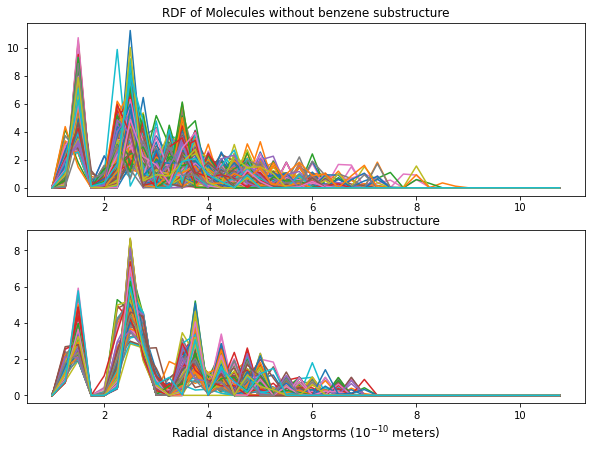

In [14]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(2, 1, figsize=(10, 7))
ax[0].plot(rs, features0.T, '-');
ax[0].set_title("RDF of Molecules without benzene substructure")
# ax[0].set_xlabel(r"Radial distance in Angstorms ($10^{-10}$ meters)")
ax[1].plot(rs, features1.T, '-');
ax[1].set_title("RDF of Molecules with benzene substructure");
ax[1].set_xlabel(r"Radial distance in Angstorms ($10^{-10}$ meters)", fontsize=12);

In [15]:
clf = sklearn.linear_model.LogisticRegression(C=1, random_state=6036, max_iter=1000).fit(train_rdf, train_labels)

print("Model train accuracy: %.3g" % clf.score(train_rdf, train_labels))
train_decisions = clf.decision_function(train_rdf)

print("Model test accuracy: %.3g" % clf.score(test_rdf, test_labels))
test_decisions = clf.decision_function(test_rdf)

Model train accuracy: 0.993
Model test accuracy: 0.99


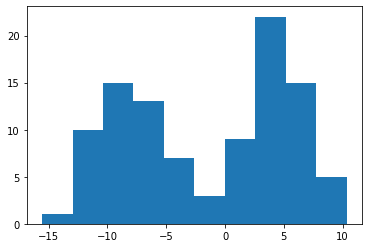

In [16]:
plt.hist(test_decisions);

If we plot $\theta$, we can get a sense for which radial distances are most important for distinguishing benzene substructure containing molecules vs. not.

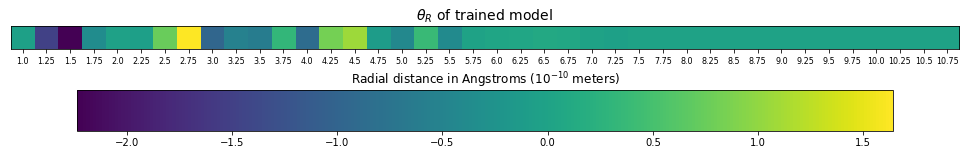

In [17]:
fig = plt.figure(figsize=(17,5))
im = plt.imshow(clf.coef_.reshape(1, -1), cmap='viridis')
ax = fig.get_axes()[0]
ax.set_xticks(range(len(rs)))
ax.set_xticklabels(map(str, rs), fontsize=8)
ax.set_yticks([])
ax.set_title(r"$\theta_R$ of trained model", fontsize=14)
ax.set_xlabel(r"Radial distance in Angstroms ($10^{-10}$ meters)", fontsize=12)

plt.colorbar(im, orientation='horizontal')

Given the higher strength of RDF values below 4.5, let's try re-training our model just on those features and see what we get.

In [18]:
just_peaks = slice(1,9)
clf = sklearn.linear_model.LogisticRegression(C=1, random_state=6036, max_iter=1000).fit(
    train_rdf[:, just_peaks], train_labels)

print("Model train accuracy: %.3g" % clf.score(train_rdf[:, just_peaks], train_labels))
train_decisions = clf.decision_function(train_rdf[:, just_peaks])

print("Model test accuracy: %.3g" % clf.score(test_rdf[:, just_peaks], test_labels))
test_decisions = clf.decision_function(test_rdf[:, just_peaks])

Model train accuracy: 0.988
Model test accuracy: 0.96


## Something to make you SMILE

We can use our more complete datafile and the [SMILES Explorer website](http://www.cheminfo.org/Chemistry/Cheminformatics/Smiles/index.html) to plot diagrams of the data. Note, that SMILES only contains bonding information not contain 3D coordinates, but this is still useful for making diagrams.

### Explore which molecules are getting misclassified

From looking at the misclassified molecules in the SMILES Explorer, what do you notice about molecules that are misclassified?

Our featurization does not weigh the radial distance function by atom type and only looks at the geometry of the molecule. How might we update our featurization to better distinguish benzene rings vs. azine (benzene rings with a carbon replaced with a nitrogen)?

In [19]:
benzene_smiles = [d['smiles'] for d in data_benzene]
no_benzene_smiles = [d['smiles'] for d in data_no_benzene]

In [20]:
misclassified_test = (clf.predict(test_rdf[:, just_peaks]) != test_labels).nonzero()[0]
misclassified_train = (clf.predict(train_rdf[:, just_peaks]) != train_labels).nonzero()[0]

test_smiles = np.concatenate([no_benzene_smiles[split:], benzene_smiles[split:]], axis=0)
train_smiles =  np.concatenate([no_benzene_smiles[:split], benzene_smiles[:split]], axis=0)

In [21]:
# 0 == no benzene, 1 == benzene
print("Correct labels for misclassified test examples: ", test_labels[misclassified_test])  # Correct labels for misclassified test examples
print("Correct labels for misclassified train examples: ", train_labels[misclassified_train])  # Correct labels for misclassified train examples

Correct labels for misclassified test examples:  [0 0 1 1]
Correct labels for misclassified train examples:  [0 0 0 1 1]


In [22]:
print(clf.decision_function(test_rdf[:, just_peaks][misclassified_test]))
print(clf.decision_function(train_rdf[:, just_peaks][misclassified_train]))

[ 0.77616079  2.82041609 -0.83849731 -0.59383423]
[ 1.46804936  0.21930625  2.27440642 -1.09550389 -0.37973425]


In [23]:
for s in test_smiles[misclassified_test]:
  print(s)

print("\n")

for s in train_smiles[misclassified_train]:
  print(s)

N#CC1C(N)C=CC1O
O=C1NCC2CC1C2O
C1=Cc2ccccc2C1
c1ccc(C2CN2)cc1


Cc1cc(N)nc(F)c1
O=C1CNC2CC1C2O
[NH-]c1cc(O)[nH+]cc1O
c1ccc(C2CC2)cc1
c1ccc2c(c1)COC2


## 6) Evaluating features for MNIST data


This problem explores how well logistic linear classification works to <a
href="http://neuralnetworksanddeeplearning.com/chap1.html">classify
images of handwritten digits</a>, from the well-known ("MNIST")
dataset, building on your thoughts from lab about extracting features
from images (like 3-block tetris).  This exercise will highlight how important feature extraction can help make your predictions more robust. In this example, we will see whether features can help make our classifier more robust to movements of the digit within the image.

We have supplied you with the `load_mnist_data` function,
which will read from the provided image files and populate a dictionary,
with image and label vectors for each numerical digit from 0 to 9.
These images are already shaped as `(m,n)` arrays.

In [24]:
mnist_data_all = hw5.load_mnist_data(range(10))

print('mnist_data_all loaded. shape of single images is', mnist_data_all[0]["images"][0].shape)

# CHANGE INDICES (initally set to [0] and [1]) TO ACCESS DIFFERENT IMAGES
# 0 vs. 1, 2 vs. 4, 6 vs. 8, 9 vs. 0
d0 = mnist_data_all[2]["images"]
d1 = mnist_data_all[4]["images"]

y0 = np.repeat(-1, len(d0))
y1 = np.repeat(1, len(d1))

# data goes into the feature computation functions
data = np.concatenate([d0, d1], axis=0)
# labels can directly go into the perceptron algorithm
labels = np.concatenate([y0, y1], axis=0)

print("Data: ", data.shape, "Labels: ", labels.shape)

mnist_data_all loaded. shape of single images is (28, 28)
Data:  (155, 28, 28) Labels:  (155,)


Here's an example MNIST digit.

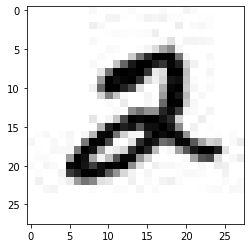

In [25]:
im = plt.imshow(d0[0], cmap='binary')

<b>Dataset setup</b>

So far in this course, we have represented features as one long feature vector. For images, however, like in MNIST and 3-block tetris, we often represent a $m$ by $n$ image
as a `(m,n)` array, rather than a `(mn,1)` array
(as the previous parts have done).

In [28]:
# Implement the following 4 encodings, we've coded an 5th encoding for you for the optional questions.

def raw_mnist_features(x):
    """
    @param x (n_samples,m,n) array with values in (0,1)
    @return (n_samples, m*n) reshaped array where each entry is preserved
    """
    pass

def row_average_features(x):
    """
    @param x (n_samples,m,n) array with values in (0,1)
    @return (n_samples, m) array where each entry is the average of a row
    """
    return np.mean(x,axis=2)


def col_average_features(x):
    """    @param x (n_samples,m,n) array with values in (0,1)
    @return (n_samples, n) array where each entry is the average of a column
    """
    return np.mean(x,axis=1)


def top_bottom_features(x):
    """
    @param x (n_samples,m,n) array with values in (0,1)
    @return (n_samples, 2) array where the first entry of each column is the average of the
    top half of the image = rows 0 to floor(m/2) [exclusive]
    and the second entry is the average of the bottom half of the image
    = rows floor(m/2) [inclusive] to m
    """
    return np.vstack((np.mean(x[:,0:int(x.shape[1]/2),:],axis=(1,2)),np.mean(x[:,int(x.shape[1]/2):,:],axis=(1,2)))).T


def fourier(x):
    """
    The Fourier Transform is an important featurization in signal processing:
    https://en.wikipedia.org/wiki/Fourier_transform
    It will output complex numbers so we are going to take the norm (with np.abs).

    How does a model trained with this transform perform on 
    translated data that it hasn't seen during training?
    """
    from scipy import fftpack
    n_examples, m, n = x.shape
    x_fft = fftpack.fft2(x, axes=(-2, -1))
    return np.abs(x_fft).reshape(n_examples, m * n)

## Linear logistic regression for classifying MNIST for various **encodings**

Let's see how well our linear logistic classifer can perform on this data given the different encodings you have implemented above. We are going to perform KFold validation, which will slit our data into 5 different groups 4 of which will be used for training and 1 for testing. We will cycle between 5 permutations of which sets are used for test vs. train.

In [33]:
n_splits = 5
kf = sklearn.model_selection.KFold(n_splits=n_splits, shuffle=True, random_state=6036)
kf.get_n_splits(data)

# CHANGE WHICH ENCODING YOU'RE USING HERE
encodings = row_average_features, col_average_features, top_bottom_features, fourier

encoding_id = 1  # 0 - 3 (for main hw) 4 (for optional)
encoding = encodings[encoding_id]

scores = 0.
for i, (train_index, test_index) in enumerate(kf.split(data)):
  clf = sklearn.linear_model.LogisticRegression(C=20, random_state=6036).fit(encoding(data)[train_index], labels[train_index])
  score = clf.score(encoding(data)[test_index], labels[test_index])
  scores += score
  print("Split {}".format(i) + " Model accuracy: %.3g" % score)
print("Average Model accuracy: %.3g" % (scores / n_splits))

Split 0 Model accuracy: 0.742
Split 1 Model accuracy: 0.484
Split 2 Model accuracy: 0.71
Split 3 Model accuracy: 0.484
Split 4 Model accuracy: 0.742
Average Model accuracy: 0.632


Plot $\theta$ learned by classifier.

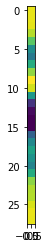

In [34]:
if encoding_id == 1: 
  plt.imshow(clf.coef_.reshape(28, 1))
elif encoding_id == 2: 
  plt.imshow(clf.coef_.reshape(1, 28))
elif encoding_id == 3:
  plt.imshow(clf.coef_.reshape(2, 1))
elif encoding_id == 4:
  plt.imshow(clf.coef_.reshape(28, 28))

## (Optional) Robustness of model to translations
If we move around the digit within the bounds of the image, it's still the same digit. But can our linear logistic classifier still correctly identify these translated digits?

Here's our translation function.

In [35]:
def translate(image, shift_col=0, shift_row=0):
  # image [n_samples, m, n] or [m, n]
  # output [n_samples, m, n] or [m, n]

  if abs(shift_col) > 5:
    raise Exception("Too much translation! Please use abs(shift_col) <= 5.")
  if abs(shift_row) > 5:
    raise Exception("Too much translation! Please use abs(shift_row) <= 5.")

  new_image = np.zeros_like(image)
  if shift_col == 0:
    new_image = image.copy()
  elif shift_col > 0:
    new_image[..., :, shift_col:] = image[..., :, :-1*shift_col]
  elif shift_col < 0:
    new_image[..., :, :shift_col] = image[..., :, -1*shift_col:]
  if shift_row == 0:
    new_image = new_image
  elif shift_row > 0:
    new_image[..., shift_row:, :] = new_image[..., :-1*shift_row, :]
  elif shift_row < 0:
    new_image[..., :shift_row, :] = new_image[..., -1*shift_row:, :]
  return new_image

Here are pictures of diferent translations of the digit within the image.

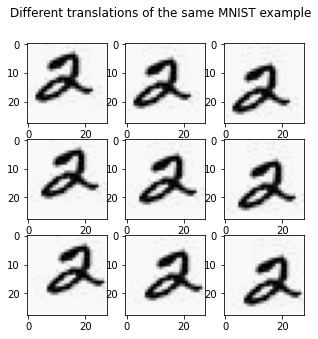

In [36]:
fig, ax = plt.subplots(3, 3, figsize=(5, 5))
plt.suptitle("Different translations of the same MNIST example")
for i in range(3):
  for j in range(3):
    ax[i, j].imshow(translate(d0[0], shift_col= (i - 1) * 2, shift_row=(j - 1) * 2), cmap='binary', vmin=-1e-4)

### Testing robustness of our model: How does it perform on translated examples with the given encoding?
To test how our model performs on translated data for the given encoding, we are going to build an new dataset with translated digits (up to 5 pixels).

In [37]:
d0_augmented = []
d1_augmented = []
for i in range(11):
  for j in range(11):
    new_d0 = translate(np.array(d0), shift_col=-5 + i, shift_row=-5 + j)
    new_d1 = translate(np.array(d1), shift_col=-5 + i, shift_row=-5 + j)
    d0_augmented.append(new_d0)
    d1_augmented.append(new_d1)

d0_augmented = np.concatenate(d0_augmented, axis=0)
d1_augmented = np.concatenate(d1_augmented, axis=0)

translated_data =  np.concatenate([d0_augmented, d1_augmented], axis=0)
translated_labels = np.array([-1] * len(d0_augmented) + [1] * len(d1_augmented))

print("Translated Data: ", translated_data.shape, "Translated Labels: ", translated_labels.shape)

Translated Data:  (18755, 28, 28) Translated Labels:  (18755,)


### First, let's try one of our previous model:

In [38]:
score = clf.score(encoding(translated_data), translated_labels)
print("Original model accuracy on translated data: %.3g" % score)

Original model accuracy on translated data: 0.696


### Training and testing on translated data
We can also test how well a linear logistic classifier performs when trained with the translated dataset. Again we'll use KFold validation.

In [41]:
n_splits = 5
kf = sklearn.model_selection.KFold(n_splits=n_splits, shuffle=True, random_state=6036)
kf.get_n_splits(translated_data)

scores = 0.
for i, (train_index, test_index) in enumerate(kf.split(translated_data)):
  clf_translated = sklearn.linear_model.LogisticRegression(C=20, random_state=6036).fit(encoding(translated_data)[train_index], translated_labels[train_index])
  score = clf_translated.score(encoding(translated_data)[test_index], translated_labels[test_index])
  scores += score
  print("Split {}".format(i) + " Model accuracy: %.3g" % score)
print("Average Model accuracy trained on translated data: %.3g" % (scores / n_splits))

Split 0 Model accuracy: 0.703
Split 1 Model accuracy: 0.691
Split 2 Model accuracy: 0.694
Split 3 Model accuracy: 0.687
Split 4 Model accuracy: 0.695
Average Model accuracy trained on translated data: 0.694


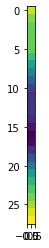

In [40]:
if encoding_id == 0:
  plt.imshow(clf_translated.coef_.reshape(28, 28))
elif encoding_id == 1: 
  plt.imshow(clf_translated.coef_.reshape(28, 1))
elif encoding_id == 2: 
  plt.imshow(clf_translated.coef_.reshape(1, 28))
elif encoding_id == 3:
  plt.imshow(clf_translated.coef_.reshape(2, 1))
elif encoding_id == 4:
  plt.imshow(clf_translated.coef_.reshape(28, 28))

## Elemental Regression 

In this problem, we'll train regression models on the elemental property trends we saw in the Week 5 exercises. We'll try out the different encodings we discussed in the excercises: real valued vs. one-hot encodings of the atomic mass (Z), group, row, and block ('s', 'p', 'd', 'f').

Recall, from Exercise 5...

The [Periodic Table of Elements](https://en.wikipedia.org/wiki/Periodic_table) is a method of organizing chemical elements by their [atomic number](https://en.wikipedia.org/wiki/Atomic_number) and [electron configuration](https://en.wikipedia.org/wiki/Electron_configuration). The Periodic Table is itself a feature representation and a useful one at that, many chemical properties 

The Periodic Table is organized into rows and columns where columns are further organized into "blocks" that correspond to the character of the outermost electron orbital 's', 'p', 'd', or 'f'.

For practicality, elements 57-70 (the Lanthanides) and elements 89-102 (the Actinides) are typically displayed below the rest of the elements.

<img src="https://go.odl.mit.edu/subject/6.036/_static/catsoop/exercises/ex05/periodic_table.jpg">

<a href="https://commons.wikimedia.org/w/index.php?title=File:Periodic_table_(32-col,_enwiki),_black_and_white.png&oldid=543349698"><font size=2>Periodic table (32-col, enwiki) (modified to add colors). Wikimedia Commons, the free media repository.</font></a>

Let's explore how different encodings of elements on the periodic table many be helpful for building linear models that can predict trends in chemical properties. We're going to use a simple 3 dimensional encoding of each element `[row, column, block]` or `[Z, row, column, block]`.

To get our element data, we use `pymatgen` which is an open-source package for material science data analysis. The [`pymatgen.core.periodic_table`](https://pymatgen.org/pymatgen.core.periodic_table.html) module includes data on many different properties the elements (atomic radius, boiling point, melting point, ionization energies, etc.).

We can plot various properties with the following function to help us query `pymatgen` and `pymatplt.periodic_table_heatmap`. We will focus on predicting Electron Affinity which had the most complex pattern out of the four properties we saw in the exercises.

In [42]:
def get_element_data(property, Zmax=118):
  data = dict()
  for i in range(1, Zmax + 1):
    elem = periodic_table.Element.from_Z(i)
    try:
      mp = getattr(elem, property)
      try:
        if np.isnan(mp):
          pass
        else:
          data[elem.symbol] = float(mp)
      except:
        if type(mp) == list:
          data[elem.symbol] = mp[0]
        else:
          pass
    except:
      pass
  return data

## Prepare the data

In [43]:
electron_affinity_dict = get_element_data('electron_affinity', Zmax=103)
ionization_energy_dict = get_element_data('ionization_energies', Zmax=103)

In [44]:
block_dict = {'s': 0, 'p': 1, 'd': 2, 'f': 3}

Z_max = 103
groups = [periodic_table.Element.from_Z(Z).group for Z in range(1, Z_max + 1)]
rows = [periodic_table.Element.from_Z(Z).row for Z in range(1, Z_max + 1)]
blocks = [block_dict[periodic_table.Element.from_Z(Z).block] for Z in range(1, Z_max + 1)]
symbols = np.array([periodic_table.Element.from_Z(Z).symbol for Z in range(1, Z_max + 1)])

group_max = max(groups)
rows_max = max(rows)
blocks_max = max(blocks)

def onehot_encoding(x, xmax):
  onehot = np.zeros([len(x)] + [xmax])
  onehot[np.arange(len(x)), np.array(x) - 1] = 1.
  return onehot

def standardize(x):
  return (x - x.mean(axis=0, keepdims=True)) / x.std(axis=0, keepdims=True)

In [45]:
# atomic number (number of protons)
Z_stand = standardize(np.arange(103)).reshape(-1, 1)
Z_onehot = onehot_encoding(np.arange(103), 103)
# group, row, block
grb_real = np.stack([groups, rows, blocks], axis=-1)
grb_stand = standardize(grb_real)
grb_onehots = np.concatenate([onehot_encoding(groups, group_max),
                              onehot_encoding(rows, rows_max),
                              onehot_encoding(blocks, blocks_max)], axis=-1)

# Create splits
np.random.seed(6036)
shuffled = np.arange(103)
np.random.shuffle(shuffled)
split = 70
train_split = shuffled[:split]
test_split = shuffled[split:]

In [46]:
from collections import OrderedDict
def create_feature_dict(split):
  d = OrderedDict()
  d.update({
      'Z_real_stand': Z_stand[split],
      'Z_onehot': Z_onehot[split],
      'grb_stand': grb_stand[split],
      'grb_onehots': grb_onehots[split],
      'grb_all': np.concatenate([grb_stand[split], grb_onehots[split]], axis=-1),
      'all': np.concatenate([Z_stand[split], Z_onehot[split], grb_stand[split], grb_onehots[split]], axis=-1),
  })
  l = OrderedDict()
  l.update({
      'electron_affinity': [electron_affinity_dict[s] for s in symbols[split]],
      'ionization_energy': [ionization_energy_dict[s] for s in symbols[split]],
  })
  return d, l

train_set, train_labels = create_feature_dict(train_split)
test_set, test_labels = create_feature_dict(test_split)

## Time to train!

`sklearn.linear_model.LinearRegression` uses the coefficient of determination $R^2$ to score models. We can read the following from the [class documentation](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html).

> The coefficient of determination  is defined as $R = 1 - \frac{u}{v}$, where  is the residual sum of squares <code>((y_true - y_pred)** 2).sum()</code> and  is the total sum of squares <code>((y_true - y_true.mean()) ** 2)</code>.sum(). The best possible score is 1.0 and it can be negative (because the model can be arbitrarily worse). A constant model that always predicts the expected value of y, disregarding the input features, would get a  score of 0.0.



In [47]:
regs = OrderedDict()
scores = OrderedDict()
for label in train_labels.keys():
  regs[label] = OrderedDict()
  scores[label] = OrderedDict()
  for key in train_set.keys():
    train, test = train_set[key], test_set[key]
    train_label, test_label = train_labels[label], test_labels[label]
    print("Task: ", label)
    print("Feature set: ", key)
    reg = sklearn.linear_model.Ridge(alpha=0.5).fit(train, train_label)
    regs[label][key] = reg 
    train_score, test_score =  reg.score(train, train_label), reg.score(test, test_label)
    scores[label][key] = {'train_score': train_score, 'test_score': test_score}
    print(r"Model Train R^2: %.3g" % train_score)
    print(r"Model Test R^2: %.3g" % test_score)
    print("----")
    # predictions = reg.predict(test)

Task:  electron_affinity
Feature set:  Z_real_stand
Model Train R^2: 0.0593
Model Test R^2: -0.285
----
Task:  electron_affinity
Feature set:  Z_onehot
Model Train R^2: 0.889
Model Test R^2: -0.0495
----
Task:  electron_affinity
Feature set:  grb_stand
Model Train R^2: 0.107
Model Test R^2: -0.284
----
Task:  electron_affinity
Feature set:  grb_onehots
Model Train R^2: 0.679
Model Test R^2: 0.361
----
Task:  electron_affinity
Feature set:  grb_all
Model Train R^2: 0.698
Model Test R^2: 0.386
----
Task:  electron_affinity
Feature set:  all
Model Train R^2: 0.96
Model Test R^2: 0.49
----
Task:  ionization_energy
Feature set:  Z_real_stand
Model Train R^2: 0.147
Model Test R^2: 0.256
----
Task:  ionization_energy
Feature set:  Z_onehot
Model Train R^2: 0.889
Model Test R^2: -0.00141
----
Task:  ionization_energy
Feature set:  grb_stand
Model Train R^2: 0.631
Model Test R^2: 0.547
----
Task:  ionization_energy
Feature set:  grb_onehots
Model Train R^2: 0.883
Model Test R^2: 0.449
----
Task

### Plots are much easier to analyze than lines of text

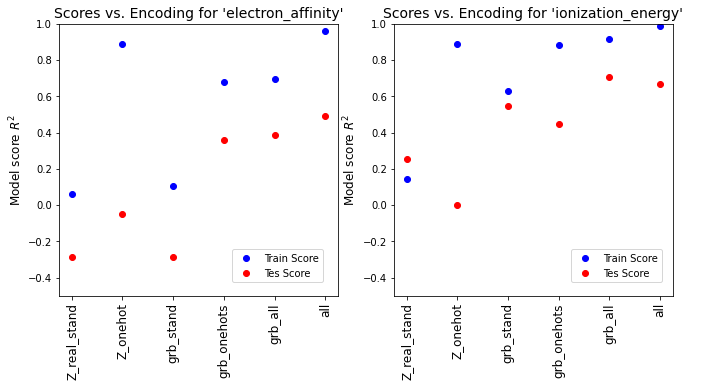

In [48]:
y_lim = [-0.5, 1.0]
fig, axes = plt.subplots(1, 2, figsize=(11, 5))
for ax, label in zip(axes, train_labels.keys()):
  keys = train_set.keys()
  ax.plot(range(len(keys)), [scores[label][key]['train_score'] for key in keys], 'bo', label='Train Score')
  ax.plot(range(len(keys)), [scores[label][key]['test_score'] for key in keys], 'ro', label='Tes Score')
  ax.set_xticks(range(len(keys)))
  ax.set_xticklabels(keys, rotation=90, fontsize=12)
  ax.set_ylabel(r"Model score $R^2$",  fontsize=12)
  ax.set_title("Scores vs. Encoding for '{}'".format(label), fontsize=14)
  ax.set_ylim(y_lim)
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc = (0.33, 0.27))

handles, labels = axes[1].get_legend_handles_labels()
fig.legend(handles, labels, loc = (0.813, 0.27))


### Other ways we can look at our results

#### Heatmap of True, Predicted, and Difference of Values

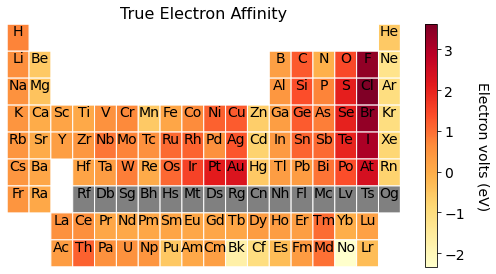

In [49]:
pymatplt.periodic_table_heatmap(get_element_data('electron_affinity', Zmax=103), cbar_label="Electron volts (eV)")
plt.title("True Electron Affinity", fontsize=16)
plt.gcf().set_size_inches(7, 3.5)

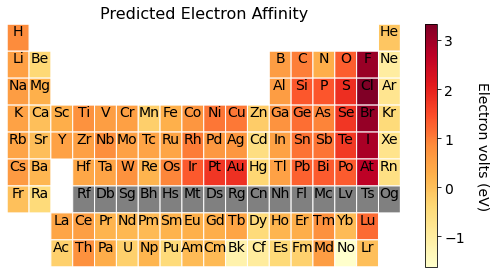

In [50]:
all_data = np.concatenate([train_set['all'], test_set['all']], axis=0)
all_symbols = np.concatenate([symbols[train_split], symbols[test_split]], axis=0)
all_pred = regs['electron_affinity']['all'].predict(all_data)
all_dict = {s: d for s,d in zip(all_symbols, all_pred)}

pymatplt.periodic_table_heatmap(all_dict, cbar_label="Electron volts (eV)")
plt.title("Predicted Electron Affinity", fontsize=16)
plt.gcf().set_size_inches(7, 3.5)

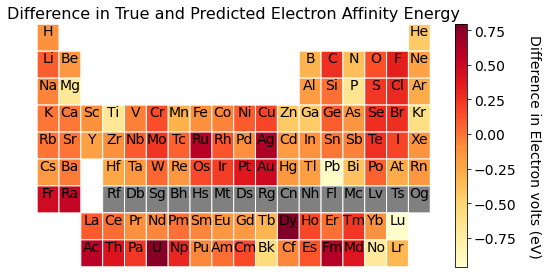

In [51]:
diff_dict = {}
ionization_energies_dict = get_element_data('electron_affinity', Zmax=103)
for key in all_dict.keys():
  diff_dict[key] =  ionization_energies_dict[key] - all_dict[key]

pymatplt.periodic_table_heatmap(diff_dict, cbar_label="Difference in Electron volts (eV)")
plt.title("Difference in True and Predicted Electron Affinity Energy", fontsize=16)
plt.gcf().set_size_inches(7, 3.5)

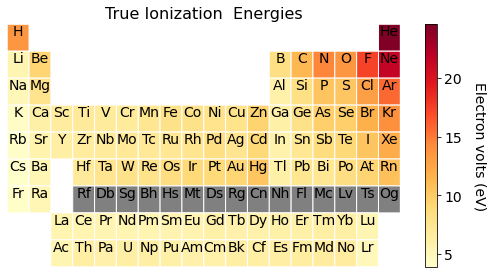

In [52]:
pymatplt.periodic_table_heatmap(get_element_data('ionization_energies', Zmax=103), cbar_label="Electron volts (eV)")
plt.title("True Ionization  Energies", fontsize=16)
plt.gcf().set_size_inches(7, 3.5)

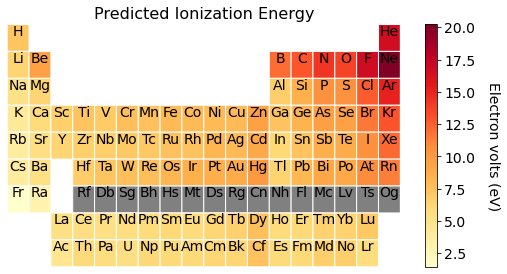

In [53]:
all_data = np.concatenate([train_set['all'], test_set['all']], axis=0)
all_symbols = np.concatenate([symbols[train_split], symbols[test_split]], axis=0)
all_pred = regs['ionization_energy']['all'].predict(all_data)
all_dict = {s: d for s,d in zip(all_symbols, all_pred)}

pymatplt.periodic_table_heatmap(all_dict, cbar_label="Electron volts (eV)")
plt.title("Predicted Ionization Energy", fontsize=16)
plt.gcf().set_size_inches(7, 3.5)

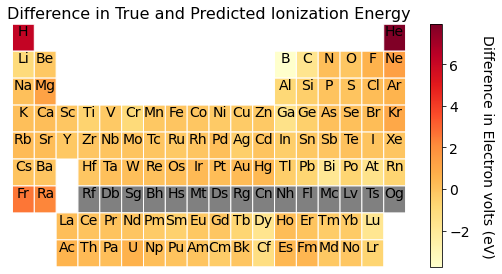

In [ ]:
diff_dict = {}
ionization_energies_dict = get_element_data('ionization_energies', Zmax=103)
for key in all_dict.keys():
  diff_dict[key] =  ionization_energies_dict[key] - all_dict[key]

pymatplt.periodic_table_heatmap(diff_dict, cbar_label="Difference in Electron volts (eV)")
plt.title("Difference in True and Predicted Ionization Energy", fontsize=16)
plt.gcf().set_size_inches(7, 3.5)

#### Plotting True vs. Predicted of Train and Test
Data Closer to the diagonal is being better predicted. How much points are or are not on the line give us information about how well the model is doing.

In [54]:
def plot_predictions(reg, train, test, train_label, test_label, title=""):
  train_pred = reg.predict(train)
  test_pred = reg.predict(test)
  vmax = max([max(train_pred), max(test_pred)])

  fig, ax = plt.subplots(1, 2, figsize=(10, 6.5))
  scat = ax[0].scatter(reg.predict(train), train_label, c=train_split, cmap='viridis')
  ax[0].set_xlabel("Train Predictions", fontsize=12)
  ax[0].set_ylabel("True Values", fontsize=12)
  ax[0].set_xlim(0, vmax)
  ax[0].set_ylim(0, vmax)
  ax[0].plot([0, vmax], [0, vmax], '--', color="#808080")

  scat = ax[1].scatter(reg.predict(test), test_label, c=test_split, cmap='viridis')
  ax[1].set_xlabel("Test Predictions", fontsize=12)
  ax[1].set_ylabel("True Values", fontsize=12)
  ax[1].set_xlim(0, vmax)
  ax[1].set_ylim(0, vmax)
  ax[1].plot([0, vmax], [0, vmax], '--', color="#808080")
  cbar = plt.colorbar(scat, ax=ax, orientation="horizontal")
  cbar.ax.set_xlabel('Atomic Number (Z)', fontsize=12);
  return plt

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.7/dist-packages/matplotlib/pyplot.py'>

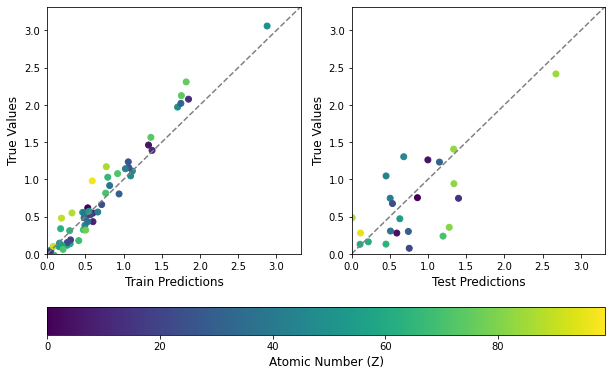

In [ ]:
key='all'
label='electron_affinity'
plot_predictions(regs[label][key], train_set[key], test_set[key], train_labels[label], test_labels[label])

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.7/dist-packages/matplotlib/pyplot.py'>

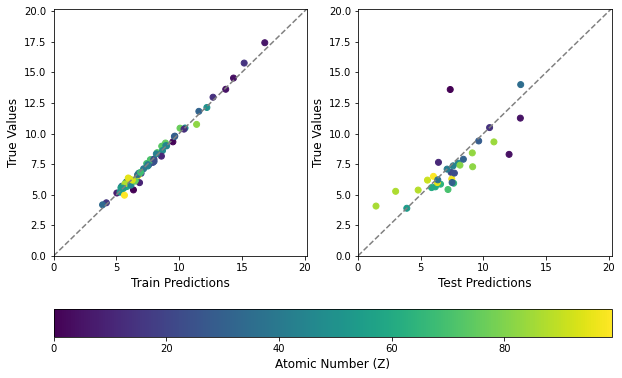

In [ ]:
key='all'
label='ionization_energy'
plot_predictions(regs[label][key], train_set[key], test_set[key], train_labels[label], test_labels[label])